In [42]:
# INICIAR
from main import main
from PDconfig import *
from frames.archivosDF import *

main()
df = abrirDF(MeLi)

In [43]:
# FILTRADO DE DATOS GENERAL
df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
df.dropna(how="all", subset=['terrenoTotal', 'terrenoEdificado'], inplace=True)

df['fechaUltimaActualizacion'] = pd.to_datetime(df['fechaUltimaActualizacion'], format='%d-%m-%Y')
df['fechaUltimaActualizacion'] = df['fechaUltimaActualizacion'].dt.strftime('%d-%m-%Y')
df.sort_values(by='fechaUltimaActualizacion', ascending=False, inplace=True)
df.drop_duplicates(subset=['coordX', 'coordY', 'precioUSD'], inplace=True, ignore_index=True)

# ELIMINAR TIPO PROP INSERVIBLES
filt = (df["tipoPropiedad"] == "CASA") | (df["tipoPropiedad"] == "DEPARTAMENTO") | (df["tipoPropiedad"] == "TERRENO")
df = df.loc[filt]

# ELIMINAR DATOS SIN CAMPOS RELEVANTES
filtro_T = (df['terrenoEdificado'] == 1)
filtro_P = ((df['precioUSD'] == 1))
df.drop(df[filtro_T | filtro_P].index, inplace=True)
df.drop(df[df['ciudad'] == 'CAPITAL FEDERAL'].index, inplace=True)

# ELIMINAR DATOS SIN VALOR VERDADERO
import numpy as np
filt = df['barrio'].str.contains('INMUEBLES', na=False)
df.loc[filt, 'barrio'] = np.nan

departamentos = ['CALAMUCHITA', 'COLON', 'CRUZ DEL EJE', 
                 'GENERAL ROCA', 'GENERAL SAN MARTIN', 'ISCHILIN', 'JUAREZ CELMAN',
                 'MARCOS JUAREZ', 'MINAS', 'POCHO', 'PUNILLA', 'RIO CUARTO', 'RIO PRIMERO',
                 'RIO SECO', 'RIO SEGUNDO', 'SAN ALBERTO', 'SAN JAVIER', 'SAN JUSTO', 
                 'SANTA MARIA', 'TERCERO ARRIBA', 'TOTORAL', 'TULUMBA', 'UNION']
filt = df['ciudad'].isin(departamentos)
df.loc[filt, 'ciudad'] = df.loc[filt, 'barrio']
filt = (df['ciudad'] == df['barrio'])
df.loc[filt, 'barrio'] = np.nan

In [44]:
# SEPARAR y FILTRAR TIPOS PROPIEDADES
terrenos = df.loc[df["tipoPropiedad"] == "TERRENO"]
casas = df.loc[df["tipoPropiedad"] == "CASA"]
deptos = df.loc[df["tipoPropiedad"] == "DEPARTAMENTO"]

# FILTRADO DEPARTAMENTOS
filt1 = (deptos['terrenoEdificado'] < 15) | (deptos['terrenoEdificado'].isna())
filt2 = deptos['terrenoTotal'].notna()
deptos.loc[filt1 & filt2, 'terrenoEdificado'] = deptos.loc[filt1 & filt2, 'terrenoTotal']

filtro_P = deptos["precioUSD"].between(deptos["precioUSD"].quantile(0.005), 
                                       deptos["precioUSD"].quantile(0.995))
filtro_E = (deptos["terrenoEdificado"].between(10, 1500))
deptos = deptos.loc[filtro_P & filtro_E]

# FILTRADO CASAS
filtro_P = casas["precioUSD"].between(casas["precioUSD"].quantile(0.005), 
                                       casas["precioUSD"].quantile(0.995))
filtro_E = casas['terrenoEdificado'].between(15, 2500)
filtro_T = (casas['terrenoTotal'].between(casas['terrenoTotal'].quantile(0.001),
                                         casas['terrenoTotal'].quantile(0.95))) | casas['terrenoTotal'].isna()
casas = casas.loc[filtro_P & filtro_E & filtro_T]

# FILTRADO TERRENOS
filtro_P = terrenos["precioUSD"].between(1500, 1000000)
filtro_T = (terrenos['terrenoTotal'].between(terrenos['terrenoTotal'].quantile(0.005),
                                             terrenos['terrenoTotal'].quantile(0.995)))
terrenos = terrenos.loc[filtro_P & filtro_T]

49


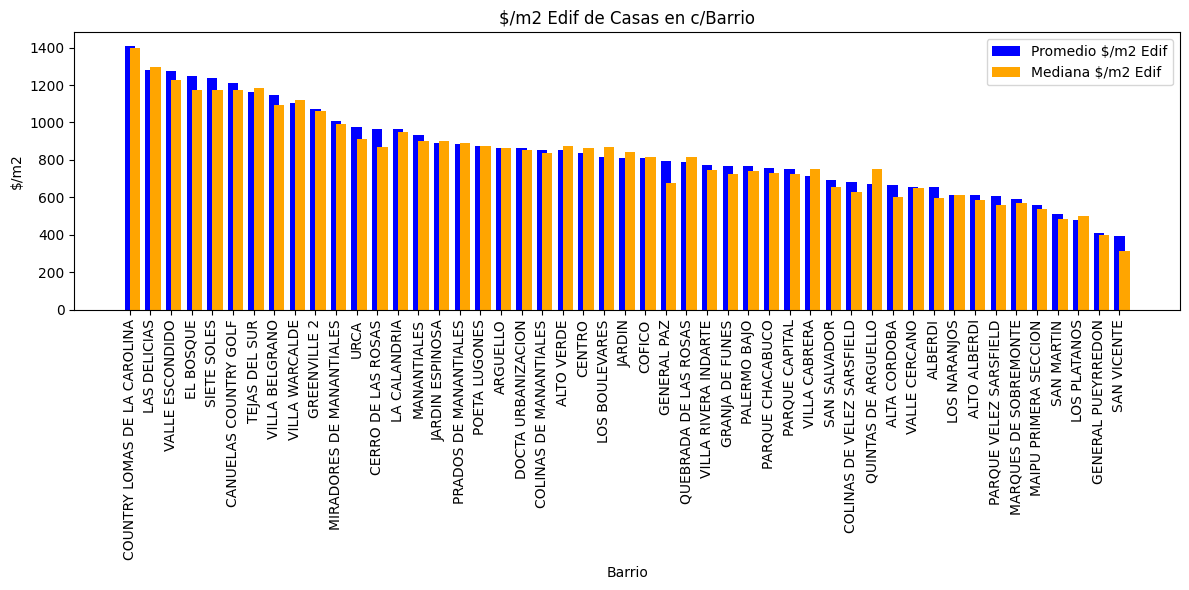

In [54]:
# ANALISIS CASAS
casas['$/m2_total'] = casas['precioUSD'] / casas['terrenoTotal']
casas['$/m2_edif'] = casas['precioUSD'] / casas['terrenoEdificado']

casas_filt = casas.loc[casas['ciudad'] == 'CORDOBA']
barrios = casas_filt.groupby(['ciudad', 'barrio'])

precio_m2_total_prom = barrios['$/m2_total'].mean().round(0)
precio_m2_total_med = barrios['$/m2_total'].median().round(0)
precio_m2_edif_prom = barrios['$/m2_edif'].mean().round(0)
precio_m2_edif_med = barrios['$/m2_edif'].median().round(0)
cantidad = barrios.size()

# Create a new DataFrame to store the calculated data
resultados = pd.DataFrame({
    'Precio_m2_total_promedio': precio_m2_total_prom,
    'Precio_m2_total_mediana': precio_m2_total_med,
    'Precio_m2_edif_promedio': precio_m2_edif_prom,
    'Precio_m2_edif_mediana': precio_m2_edif_med,
    'Cantidad': cantidad
})
resultados.reset_index(inplace=True)

results_df = resultados[['barrio', 'Precio_m2_edif_promedio', 'Precio_m2_edif_mediana', 'Precio_m2_total_promedio', 'Precio_m2_total_mediana', 'Cantidad']]
# Assuming you have a DataFrame named 'results_df' and you want to save it to an Excel file named 'results.xlsx'
results_df.to_excel('./DataFrames/MeLi/Analisis/Inmuebles/casas_barrios_ML.xlsx', index=False)


import matplotlib.pyplot as plt


resultados['indice'] = (resultados['Precio_m2_edif_promedio'] + resultados['Precio_m2_edif_mediana'])/2
resultados.sort_values("Precio_m2_edif_promedio", ascending=False, inplace=True)
resultados = resultados[(resultados["Cantidad"] > 20)]
plt.figure(figsize=(12, 6))
barrio_names = resultados['barrio']
print(len(barrio_names))
bar_width = 0.5


# Plot the bar for average house cost
plt.bar(barrio_names, resultados['Precio_m2_edif_promedio'], width=bar_width, label='Promedio $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, resultados['Precio_m2_edif_mediana'], width=bar_width, label='Mediana $/m2 Edif', color='orange', align='edge')

#plt.bar(barrio_names, resultados['indice'], width=bar_width, label='Indice Precio', color='blue')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('$/m2 Edif de Casas en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


21


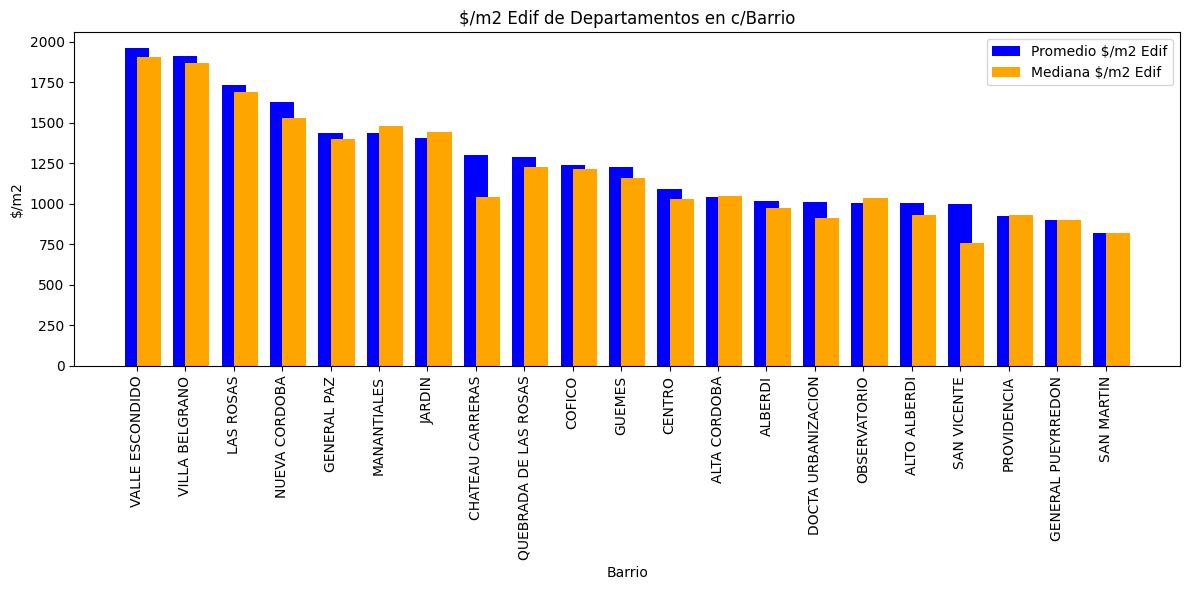

In [55]:
# ANALISIS DEPARTAMENTOS
deptos['$/m2_total'] = deptos['precioUSD'] / deptos['terrenoTotal']
deptos['$/m2_edif'] = deptos['precioUSD'] / deptos['terrenoEdificado']

deptos_filt = deptos.loc[deptos['ciudad'] == 'CORDOBA']
barrios = deptos_filt.groupby(['ciudad', 'barrio'])

precio_m2_total_prom = barrios['$/m2_total'].mean().round(0)
precio_m2_total_med = barrios['$/m2_total'].median().round(0)
precio_m2_edif_prom = barrios['$/m2_edif'].mean().round(0)
precio_m2_edif_med = barrios['$/m2_edif'].median().round(0)
cantidad = barrios.size()

# Create a new DataFrame to store the calculated data
resultados = pd.DataFrame({
    'Precio_m2_total_promedio': precio_m2_total_prom,
    'Precio_m2_total_mediana': precio_m2_total_med,
    'Precio_m2_edif_promedio': precio_m2_edif_prom,
    'Precio_m2_edif_mediana': precio_m2_edif_med,
    'Cantidad': cantidad
})
resultados.reset_index(inplace=True)

results_df = resultados[['barrio', 'Precio_m2_edif_promedio', 'Precio_m2_edif_mediana', 'Precio_m2_total_promedio', 'Precio_m2_total_mediana', 'Cantidad']]
# Assuming you have a DataFrame named 'results_df' and you want to save it to an Excel file named 'results.xlsx'
results_df.to_excel('./DataFrames/MeLi/Analisis/Inmuebles/deptos_barrios_ML.xlsx', index=False)

import matplotlib.pyplot as plt


resultados['indice'] = (resultados['Precio_m2_edif_promedio'] + resultados['Precio_m2_edif_mediana'])/2
resultados.sort_values("Precio_m2_edif_promedio", ascending=False, inplace=True)
resultados = resultados[(resultados["Cantidad"] > 20)]
plt.figure(figsize=(12, 6))
barrio_names = resultados['barrio']
print(len(barrio_names))
bar_width = 0.5


# Plot the bar for average house cost
plt.bar(barrio_names, resultados['Precio_m2_edif_promedio'], width=bar_width, label='Promedio $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, resultados['Precio_m2_edif_mediana'], width=bar_width, label='Mediana $/m2 Edif', color='orange', align='edge')

#plt.bar(barrio_names, resultados['indice'], width=bar_width, label='Indice Precio', color='blue')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('$/m2 Edif de Departamentos en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


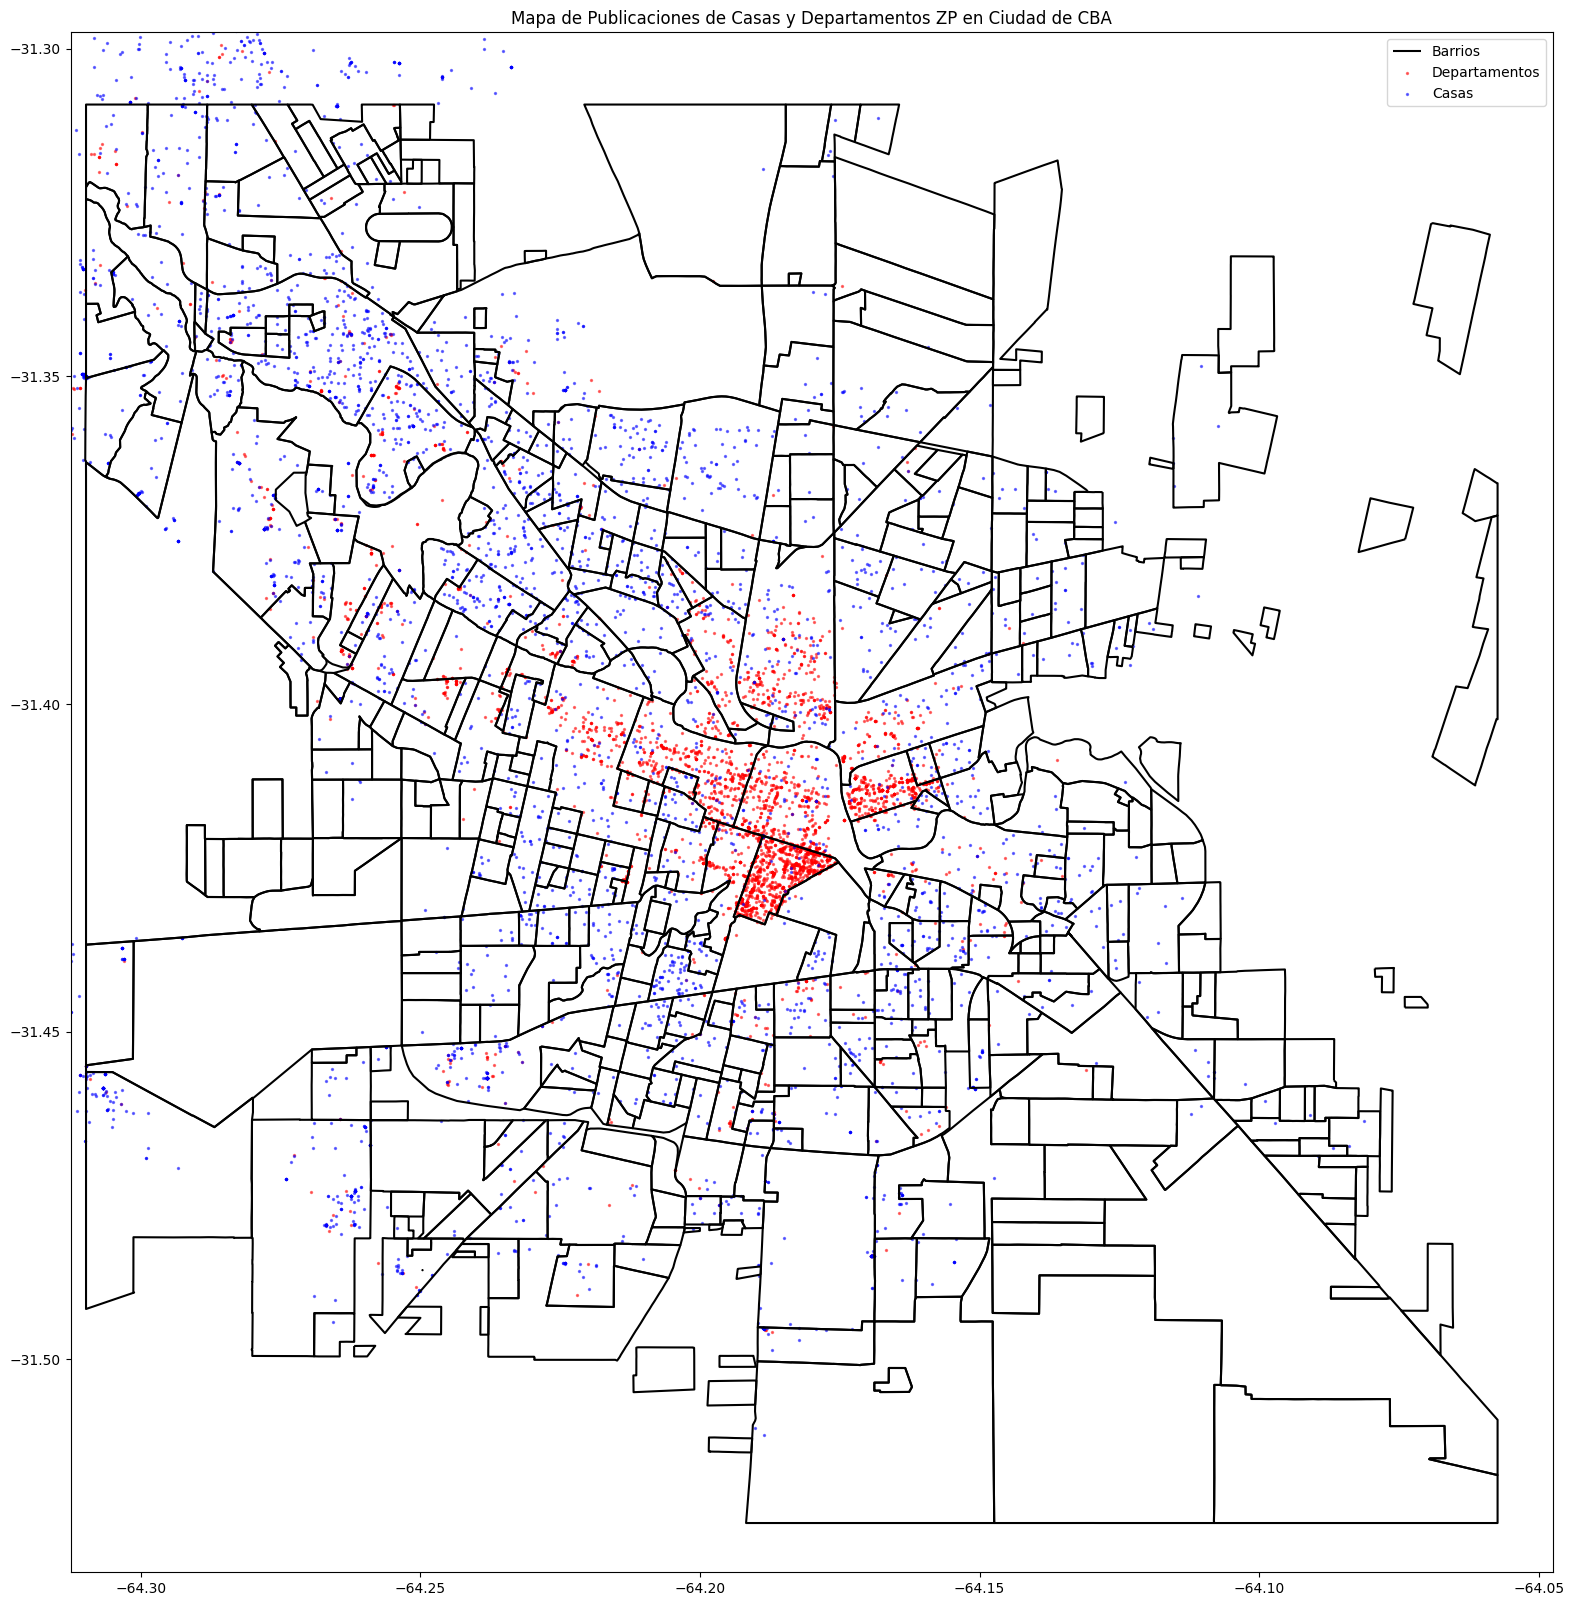

In [47]:
# MAPA COMBINADO (C y D) CIUDAD DE CBA
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj

filt = deptos['coordX'].notna()
ubicados_d = deptos[filt]
filt = casas['coordX'].notna()
ubicados_c = casas[filt]

# Define the source and target coordinate systems
source_crs = pyproj.CRS("EPSG:4326")  # WGS84 (latitude and longitude)
# Create a transformer
latitudes_d, longitudes_d = ubicados_d['coordX'], ubicados_d['coordY']
latitudes_c, longitudes_c = ubicados_c['coordX'], ubicados_c['coordY']

# Read the shapefiles
barrios_shp = './utils/maps/barrios.shp'
barrios = gpd.read_file(barrios_shp)
center = (-64.18365408774824, -31.41675384652835)


# Create a plot with the boundaries of both shapefiles
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the boundaries of radios_urbanos shapefile
barrios.boundary.plot(ax=ax, color='black', label='Barrios')

# Plot the transformed points with smaller markers and more transparency
ax.scatter(longitudes_d, latitudes_d, color='red', label='Departamentos', s=2, alpha=0.5)
ax.scatter(longitudes_c, latitudes_c, color='blue', label='Casas', s=2, alpha=0.5)

map_padding = 0.0125  # Increase the padding for more zoom-out effect
ax.set_xlim(-64.30-map_padding, -64.06 + map_padding)
ax.set_ylim(-31.52-map_padding, -31.31 + map_padding)

# Set the title and legend
ax.set_title('Mapa de Publicaciones de Casas y Departamentos ZP en Ciudad de CBA')
ax.legend()

# Show the plot
plt.show()


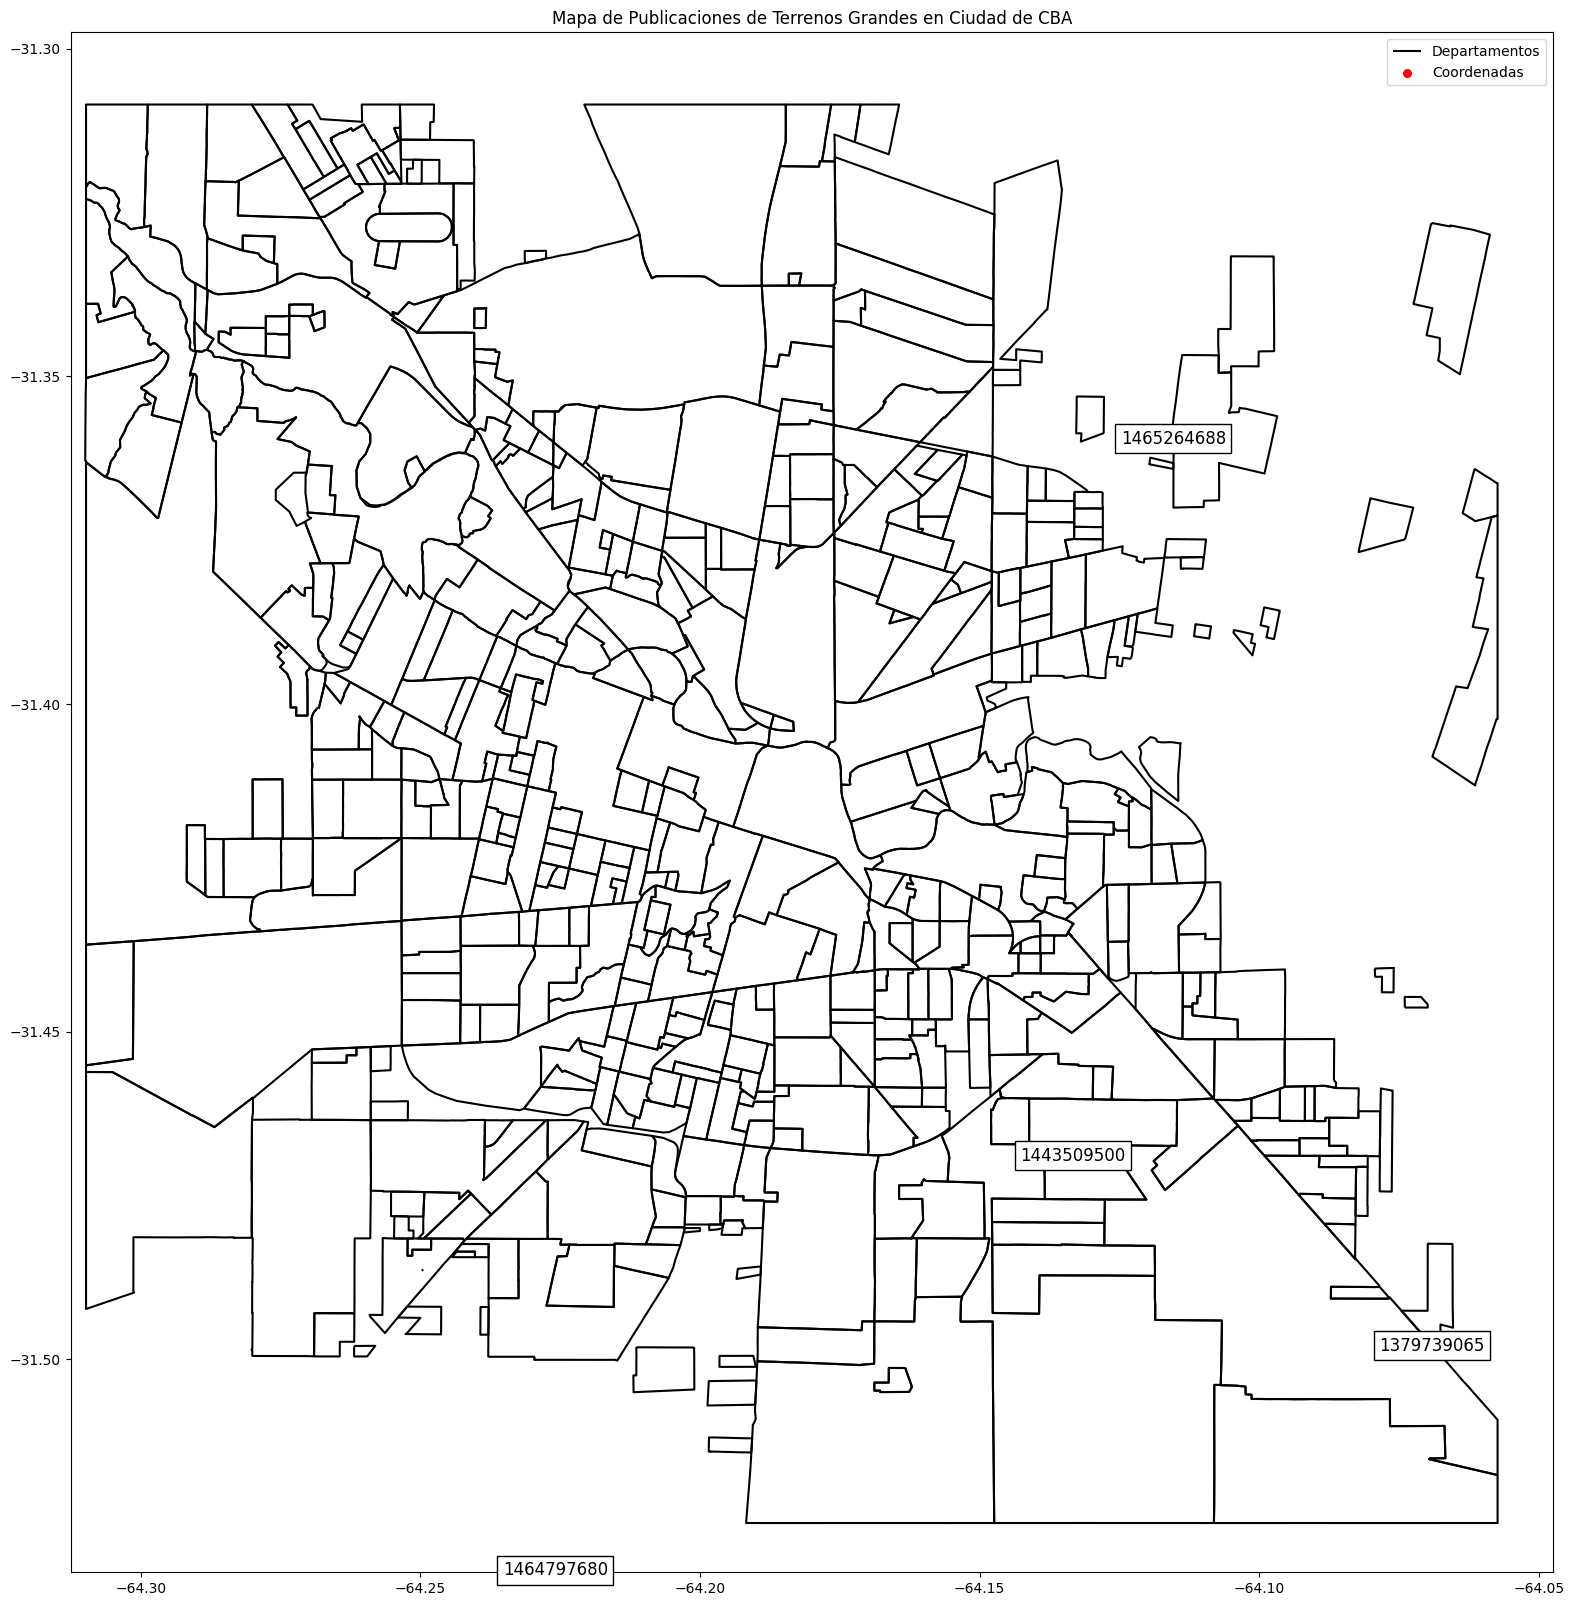

In [48]:
# ANALISIS TERRENOS

# Terrenos grandes: para desarrollos
filt = (terrenos['terrenoTotal'] >= 10000) & (terrenos['ciudad'] == 'CORDOBA') & terrenos['activo']
terrenos_grandes = terrenos.loc[filt]


import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame terrenos_grandes with columns 'coordX', 'coordY', and 'id'

# Read the shapefiles
barrios_shp = './utils/maps/barrios.shp'
barrios = gpd.read_file(barrios_shp)
center = (-64.18365408774824, -31.41675384652835)

# Create a plot with the boundaries of both shapefiles
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the boundaries of barrios shapefile
barrios.boundary.plot(ax=ax, color='black', label='Barrios')

# Plot the points
scatter = ax.scatter(terrenos_grandes['coordY'], terrenos_grandes['coordX'], color='red', label='Coordenadas', s=30)

# Add labels for each point
for idx, row in terrenos_grandes.iterrows():
    ax.annotate(str(row['id']), (row['coordY'], row['coordX']), fontsize=12,
                ha='center', va='center', color='black', backgroundcolor='white', bbox=dict(facecolor='white', edgecolor='black'))

map_padding = 0.0125  # Increase the padding for more zoom-out effect
ax.set_xlim(-64.30 - map_padding, -64.06 + map_padding)
ax.set_ylim(-31.52 - map_padding, -31.31 + map_padding)

# Set the title and legend
ax.set_title('Mapa de Publicaciones de Terrenos Grandes en Ciudad de CBA')
ax.legend()

# Show the plot
plt.savefig(f"output_map.png", dpi=300, bbox_inches="tight")
plt.show()

filt = (terrenos_grandes['coordY'].between((-64.30-map_padding), (-64.06 + map_padding)) 
        & terrenos_grandes['coordX'].between((-31.52-map_padding), (-31.31 + map_padding)))
resultados = terrenos_grandes.loc[filt]
results_df = resultados[['id','precioUSD', 'terrenoTotal', 'URL']]
# Assuming you have a DataFrame named 'results_df' and you want to save it to an Excel file named 'results.xlsx'
results_df.to_excel('./DataFrames/MeLi/Analisis/Terrenos/terrenos_grandes_ML.xlsx', index=False)

In [51]:
# DOCTA
filt = (df['barrio'].str.contains('DOCTA') | df['URL'].str.contains('DOCTA')) & (df['ciudad'] == 'CORDOBA') & df['activo']
resultados = df[filt]

results_df = resultados[['id','tipoPropiedad','precioUSD','fechaUltimaActualizacion','vendedor','terrenoTotal','terrenoEdificado','cantDormitorios','cantBanos','cantCochera','barrio','URL']]
# Assuming you have a DataFrame named 'results_df' and you want to save it to an Excel file named 'results.xlsx'
results_df.to_excel('./DataFrames/MeLi/Analisis/Inmuebles/Manantiales-Docta/docta_ML.xlsx', index=False)

In [52]:
# MANANTIALES
filt = (df['barrio'].str.contains('MANANTIALES') | df['URL'].str.contains('MANANTIALES')) & (df['ciudad'] == 'CORDOBA') & df['activo']
resultados = df[filt]

results_df = resultados[['id','tipoPropiedad','precioUSD','fechaUltimaActualizacion','vendedor','terrenoTotal','terrenoEdificado','cantDormitorios','cantBanos','cantCochera','barrio','URL']]
# Assuming you have a DataFrame named 'results_df' and you want to save it to an Excel file named 'results.xlsx'
results_df.to_excel('./DataFrames/MeLi/Analisis/Inmuebles/Manantiales-Docta/manantiales_ML.xlsx', index=False)

In [53]:
#APTO DUPLEX
filt = (terrenos['URL'].str.contains('apto') | terrenos['URL'].str.contains('dup')) & terrenos['activo']
results_df = terrenos.loc[filt, ['id','precioUSD', 'terrenoTotal', 'fechaUltimaActualizacion', 'URL']]
results_df.to_excel('./DataFrames/MeLi/Analisis/Terrenos/apto_duplex.xlsx', index=False)
results_df


,id,precioUSD,terrenoTotal,fechaUltimaActualizacion,URL
82,1380827197,350000,1200.0,31-07-2023,https://terreno.mercadolibre.com.ar/MLA-138082...
453,1380479215,24900,250.0,29-06-2023,https://terreno.mercadolibre.com.ar/MLA-138047...
559,1460975474,31500,269.0,28-07-2023,https://terreno.mercadolibre.com.ar/MLA-146097...
606,1380728001,28000,258.0,28-06-2023,https://terreno.mercadolibre.com.ar/MLA-138072...
706,1380192115,32000,1050.0,27-07-2023,https://terreno.mercadolibre.com.ar/MLA-138019...
773,1460313808,44900,364.0,27-07-2023,https://terreno.mercadolibre.com.ar/MLA-146031...
774,1460339102,42700,364.0,27-07-2023,https://terreno.mercadolibre.com.ar/MLA-146033...
1292,1457336428,600000,334.0,24-07-2023,https://terreno.mercadolibre.com.ar/MLA-145733...
1297,1379348169,130000,600.0,24-07-2023,https://terreno.mercadolibre.com.ar/MLA-137934...
1686,1455216568,165000,5000.0,21-07-2023,https://terreno.mercadolibre.com.ar/MLA-145521...
